In [29]:
import pandas as pd
import numpy as np
from IPython.display import display

import requests
from PIL import Image
from io import BytesIO

from transformers import CLIPProcessor, CLIPModel
import torch

import chromadb
import os

# Reload data
df = pd.read_csv('/Users/brunamedeiros/Documents/GitHub/Amazon-Multimodal-Chatbot/data.csv')
print(f"df has {len(df)} products")
exploded_df = pd.read_csv('/Users/brunamedeiros/Documents/GitHub/Amazon-Multimodal-Chatbot/exploded_df.csv')
print(f"exploded_df has {len(exploded_df)} products")

# Reconnect to vector store

# OLD
#client = chromadb.PersistentClient(path="./my_vectorstore")
#collection = client.get_or_create_collection(name="amazon_products")

client = chromadb.PersistentClient(path="./my_vectorstore_exploded")
collection = client.get_or_create_collection(name="amazon_products_exploded") 
print(f"Vector store was reconnected! total embeddings: {collection.count()}\n")

# Reload CLIP model
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

df has 10002 products
exploded_df has 43870 products
Vector store was reconnected! total embeddings: 0



In [ ]:
# # Delete code inside vector store
# all_data = collection.get()
# if all_data['ids']:
#     collection.delete(ids=all_data['ids'])
#     print(f"Deleted {len(all_data['ids'])} embeddings")
# else:
#     print("No embeddings to delete")

Deleted 4 embeddings


# EDA

- `Image` and `Variants` column, if my understanding is correct, have the identical image. The `Image` column has an actual image while the `Variants` has the link to the Amazon site for that specific product. A lot of those products are not on Amazon anymore so the link leads to an error.

In [5]:

print("="*60)
print("Entire dataset:")
print("="*60)
display(df.head(1))

print("="*60)
print("Dataset shape:")
print("="*60)
print(df.shape)


print("\n")
print("="*60)
print("Columns in the dataset:")
print("="*60)
print(df.columns.tolist())

print("\n")
print("="*60)
print("Column types:")
print("="*60)
print(df.dtypes)

print("\n")
print("="*60)
print("NaN counts:")
print("="*60)
print(df.isna().sum())

print("\n")
print("="*60)
print("Columns where all values are NaN:")
print("="*60)
print("The columns that should be removed because all values are NaN are:")
for col in df.columns:
    if df[col].isna().sum() == df.shape[0]:
        print(f"  {col}")


print("\n")
print("="*60)
print("Columns we can work with")
print("="*60)

for col in df.columns:
    if df[col].isna().sum() != df.shape[0]:
        print(f"  {col}")
valid_cols = [col for col in df.columns if df[col].isna().sum() != df.shape[0]]


print("\n")
print("="*60)
print("Final Dataset")
print("="*60)
display(df[valid_cols].head(1))


Entire dataset:


,Uniq Id,Product Name,Brand Name,Asin,Category,Upc Ean Code,List Price,Selling Price,Quantity,Model Number,...,Product Url,Stock,Product Details,Dimensions,Color,Ingredients,Direction To Use,Is Amazon Seller,Size Quantity Variant,Product Description
0,4c69b61db1fc16e7013b43fc926e502d,"DB Longboards CoreFlex Crossbow 41"" Bamboo Fib...",NaN,NaN,Sports & Outdoors | Outdoor Recreation | Skate...,NaN,NaN,$237.68,NaN,NaN,...,https://www.amazon.com/DB-Longboards-CoreFlex-...,NaN,NaN,NaN,NaN,NaN,NaN,Y,NaN,NaN


Dataset shape:
(10002, 28)


Columns in the dataset:
['Uniq Id', 'Product Name', 'Brand Name', 'Asin', 'Category', 'Upc Ean Code', 'List Price', 'Selling Price', 'Quantity', 'Model Number', 'About Product', 'Product Specification', 'Technical Details', 'Shipping Weight', 'Product Dimensions', 'Image', 'Variants', 'Sku', 'Product Url', 'Stock', 'Product Details', 'Dimensions', 'Color', 'Ingredients', 'Direction To Use', 'Is Amazon Seller', 'Size Quantity Variant', 'Product Description']


Column types:
Uniq Id                   object
Product Name              object
Brand Name               float64
Asin                     float64
Category                  object
Upc Ean Code              object
List Price               float64
Selling Price             object
Quantity                 float64
Model Number              object
About Product             object
Product Specification     object
Technical Details         object
Shipping Weight           object
Product Dimensions        objec

,Uniq Id,Product Name,Category,Upc Ean Code,Selling Price,Model Number,About Product,Product Specification,Technical Details,Shipping Weight,Product Dimensions,Image,Variants,Product Url,Is Amazon Seller
0,4c69b61db1fc16e7013b43fc926e502d,"DB Longboards CoreFlex Crossbow 41"" Bamboo Fib...",Sports & Outdoors | Outdoor Recreation | Skate...,NaN,$237.68,NaN,Make sure this fits by entering your model num...,Shipping Weight: 10.7 pounds (View shipping ra...,NaN,10.7 pounds,NaN,https://images-na.ssl-images-amazon.com/images...,https://www.amazon.com/DB-Longboards-CoreFlex-...,https://www.amazon.com/DB-Longboards-CoreFlex-...,Y


# Data Cleaning
- Strip `Uniq id` column
    - we will use that as naming for the images and metadata for embedding. we are using .strip() to ensure no errors arise later
- Clean URLs: ended up not using this one because checking every URL will take a long time

In [ ]:
print("Cleaning Uniq Id column (.strip())...")
df['Uniq Id'] = df['Uniq Id'].astype(str).str.strip()
print()
print(df['Uniq Id'].head())

# Check for any issues
print(f"\nUnique IDs: {df['Uniq Id'].nunique()}")
print(f"Any duplicates: {df['Uniq Id'].duplicated().sum()}")

Cleaning Uniq Id column (.strip())...

0    4c69b61db1fc16e7013b43fc926e502d
1    66d49bbed043f5be260fa9f7fbff5957
2    2c55cae269aebf53838484b0d7dd931a
3    18018b6bc416dab347b1b7db79994afa
4    e04b990e95bf73bbe6a3fa09785d7cd0
Name: Uniq Id, dtype: object

Unique IDs: 10002
Any duplicates: 0


In [23]:
# def clean_product_url(url):
#     """Check if URL is valid, return None if broken. This is to ensure Chatbot doesn't give a broken URL to consumer"""
#     # 1. check if URL exists 
#         # pd.isna(url)
#     # 2. check URL format: does it start with http?
#         # str(url).startswith('http')
#     # 3. Test URL: send quick response to see if it works
#         # requests.head(url)
#         # status_code == 200

#     if pd.isna(url) or not str(url).startswith('http'):
#         return np.nan
    
#     try:
#         response = requests.head(str(url), timeout=5)
#         if response.status_code == 200:
#             return str(url)
#         else:
#             return np.nan
#     except:
#         return np.nan

# df['Clean_Product_Url'] = df['Product Url'].apply(clean_product_url)
# print(f"Original URLs: {df['Product Url'].notna().sum()}")
# print(f"Working URLs: {df['clean_product_url'].notna().sum()}")

# Image Embedding

Each inidivual row under `Image` column has more than one https link in it.

For instance, row 1: `https://images-na.ssl-images-amazon.com/images/I/51j3fPQTQkL.jpg|https://images-na.ssl-images-amazon.com/images/I/31hKM3cSoSL.jpg|https://images-na.ssl-images-amazon.com/images/I/51WlHdwghfL.jpg|https://images-na.ssl-images-amazon.com/images/I/51FsyLRBzwL.jpg|https://images-na.ssl-images-amazon.com/images/G/01/x-locale/common/transparent-pixel.jpg`

Each product has more than 1 image (showing different perspectives of product). Instead of putting them in a different column, they concatenated all URLs in the same one, dividing them by the |

---

The `download_first_image` does the following (**WE DIDN'T USE THIS ONE**):
- separate the many https through the |
- skip the transparent pixel
    - the transparent pixel is a 1x1 pixel invisible image that Amazon uses a placeholder/tracking pixel.It looks like this `https://images-na.ssl-images-amazon.com/images/G/01/x-locale/common/transparent-pixel.jpg`. It's literally a transparent image Amazon uses for things such as web tracking, analytics, layout spacing... Therefore, we need to remove it, or else our CLIP model will try to embed an empty image).
- Saves one image per product
    - Majority of products (cell in `Image` column) have more than 1 image per product. We could either save 1 image per product or save all images per product. This function only saves one image per product as it is more feasible with the project deadline. It would be much more complex to handle CLIP if we were to have more than 1 image
- Name images as the `Uniq Id`: easy to look up
    - When we connect to Chroma and create embeddings, we can store `Uniq Id` as metadata

`download_first_image` was the first attempt. now we changed to `get_image_embedding_from_url`. It does the same as the previous one but:
- doesn't save images locally. It processes image and automatically embed them into chroma.

In [ ]:
# model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
# processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# def get_image_embedding(image):
#     inputs = processor(images=[image], return_tensors="pt", padding=True)
#     with torch.no_grad():
#         embedding = model.get_image_features(**inputs)
#     return embedding.numpy()[0]


# # LIGHT METADATA
# def get_image_embedding_from_url(url_string, uniq_id):
#     """Download image from URL and get CLIP embedding + metadata - no saving on local"""
#     try:
#         # split by | and get all urls
#         urls = url_string.split('|')

#         # find first URL that is not a transparent pixel
#         for url in urls:
#             url = url.strip()
#             if 'transparent-pixel.jpg' not in url:
#                 print(f"Trying: {url}")

#                 # download to memory (not disk)
#                 response = requests.get(url)
#                 if response.status_code == 200:
#                     # get image
#                     image = Image.open(BytesIO(response.content))

#                     # get CLIP embedding
#                     embedding = get_image_embedding(image) # This just returns a numpy array - no metadata! Therefore, need to add metadata

#                     # Metadata
#                     metadata = {
#                         "uniq_id": str(uniq_id),
#                         "type": "image"
#                     }

#                     #print(f"Got embedding for {uniq_id}")
#                     return embedding, metadata
        
#         # If no URLs worked
#         print(f"No valid URLs found for {uniq_id}")
#         return None, None

#     except Exception as e:
#         print(f"ERROR: {e}")
#         return None, None


# # Create/connect to vector store
# client = chromadb.PersistentClient(path="./my_vectorstore")
# collection = client.get_or_create_collection(name="amazon_products")

# # BATCH PROCESSING SETUP
# BATCH_SIZE = 100  # Process 100 images at a time
# embeddings_to_store = []
# metadatas_to_store = []
# ids_to_store = []

    
# # # Check/delete existing data
# # print(f"Current embeddings in store: {collection.count()}\n")
# # if collection.count() > 0:
# #     response = input("Delete existing data? (y/n): ")
# #     if response.lower() == 'y':
# #         all_data = collection.get()
# #         collection.delete(ids=all_data['ids'])
# #         print("Deleted existing data\n")


# # EMBED 
# for i in range(len(df)):
#     if i < len(df) and pd.notna(df['Image'].iloc[i]):
#         uniq_id = df['Uniq Id'].iloc[i]  # Just get uniq_id

#         # Skip if image was already embedded
#         try:
#             existing = collection.get(ids=[f"img_{uniq_id}"])
#             if existing['ids']:  # If it exists, skip
#                 print(f"Skipping {uniq_id} - already exists")
#                 continue
#         except:
#             pass  # Doesn't exist, continue processing

#         url_string = df['Image'].iloc[i]

#         embedding, metadata = get_image_embedding_from_url(url_string, uniq_id)  # Pass uniq_id
#         if embedding is not None:
#             embeddings_to_store.append(embedding.tolist())  # Convert to list
#             metadatas_to_store.append(metadata)
#             ids_to_store.append(f"img_{uniq_id}")  # Unique ID for Chroma
            
#             #print(f"Embedding shape: {embedding.shape}")
#             #print("Metadata:", metadata)
#             #print("-" * 50)
        
#         # Store every BATCH_SIZE embeddings
#         if len(embeddings_to_store) >= BATCH_SIZE:
#             collection.add(embeddings=embeddings_to_store, metadatas=metadatas_to_store, ids=ids_to_store)
#             print(f"Stored batch of {len(embeddings_to_store)} embeddings")
#             # Clear lists for next batch
#             embeddings_to_store = []
#             metadatas_to_store = []
#             ids_to_store = []

# # # Store all embeddings at once
# # if embeddings_to_store:
# #     collection.add(
# #         embeddings=embeddings_to_store,
# #         metadatas=metadatas_to_store,
# #         ids=ids_to_store
# #     )
# #     print(f"Stored {len(embeddings_to_store)} embeddings in vector store!")

# # Store final batch (if any remaining)
# if embeddings_to_store:
#     collection.add(embeddings=embeddings_to_store, metadatas=metadatas_to_store, ids=ids_to_store)
#     print(f"Stored final batch of {len(embeddings_to_store)} embeddings")


Skipping 4c69b61db1fc16e7013b43fc926e502d - already exists
Skipping 66d49bbed043f5be260fa9f7fbff5957 - already exists
Skipping 2c55cae269aebf53838484b0d7dd931a - already exists
Skipping 18018b6bc416dab347b1b7db79994afa - already exists
Skipping e04b990e95bf73bbe6a3fa09785d7cd0 - already exists
Skipping f8c32a45e507a177992973cf0d46d20c - already exists
Skipping 40d3cd16b41970ae6872e914aecf2c8e - already exists
Skipping bc178f33a04dbccefa95b165f8b56830 - already exists
Skipping cc2083338a16c3fe2f7895289d2e98fe - already exists
Skipping 69828c5570dcdbd1609216d33fbad0db - already exists
Skipping 7b0746d8afc8462ba17f8a763d9d5f1e - already exists
Skipping c5f4c94653a3befd8dd16adf2914c04e - already exists
Skipping 615ba903c134f439eaf8cdd1678ceb5c - already exists
Skipping 82c86a4d24dce5e14303033d7b658b78 - already exists
Skipping 1ecccb43e0f5c0162218371916ffa553 - already exists
Skipping d1ac6d805fcdf75f9e00af611dd03ce4 - already exists
Skipping d82015ffbf4cd54b0edfb890002971f3 - already exis

### CLIP with exploded_df

In [72]:
def get_image_embedding(image):
    inputs = processor(images=[image], return_tensors="pt", padding=True)
    with torch.no_grad():
        embedding = model.get_image_features(**inputs)
    return embedding.numpy()[0]


def get_image_embedding_from_single_url(url_string, uniq_id):
    """Download image from URL and get CLIP embedding + metadata - no saving on local"""
    url = url_string.strip()
    try:
        # find first URL that is not a transparent pixel
        if 'transparent-pixel.jpg' not in url:
            print(f"Trying: {url}")

            # download to memory (not disk)
            response = requests.get(url)
            if response.status_code == 200:
                
                # get image
                image = Image.open(BytesIO(response.content))

                # get CLIP embedding
                embedding = get_image_embedding(image) # This just returns a numpy array - no metadata! Therefore, need to add metadata

                # Metadata
                metadata = {
                    "uniq_id": str(uniq_id),
                    "type": "image"
                }
                return embedding, metadata
        
        # If no URLs worked
        print(f"No valid URLs found for {uniq_id}")
        return None, None

    except Exception as e:
        print(f"ERROR: {e}")
        return None, None

# BATCH PROCESSING SETUP
BATCH_SIZE = 100  # Process 100 images at a time
embeddings_to_store = []
metadatas_to_store = []
ids_to_store = []

In [73]:
print("="*80)
print("TESTING IMAGE EMBEDDING")
print("="*80)


print("-"*80)
print("Selecting 4 images linked to same product")
print("-"*80)
# Testing with 4 rows (those 4 images are linked to the same product)
test_df = exploded_df[exploded_df['Uniq Id'] == '4c69b61db1fc16e7013b43fc926e502d'].head(4)
print(test_df[['Uniq Id', 'Image']])


print("-"*80)
print("EMBEDDING")
print("-"*80)
#for i in range(len(exploded_df)):
for i in range(len(test_df)):

    row = exploded_df.iloc[i]
    if pd.notna(row['Image']):
        uniq_id = row['Uniq Id']
        single_url = row['Image']

        # create unique ChromaDB ID for each image
        unique_chroma_id = f"img_{uniq_id}_{i}"


        # Skip if image was already embedded
        try:
            existing = collection.get(ids=[unique_chroma_id])
            if existing['ids']: 
                print(f"Skipping {unique_chroma_id} - already exists")
                continue
        except:
            pass

        embedding, metadata = get_image_embedding_from_single_url(single_url, uniq_id)  # Just like old code
        if embedding is not None:  # Just like old code
            embeddings_to_store.append(embedding.tolist())
            metadatas_to_store.append(metadata)
            ids_to_store.append(unique_chroma_id)
            
            #print(f"Embedding shape: {embedding.shape}")
            #print("Metadata:", metadata)
            #print("-" * 50)
        
        # Store every BATCH_SIZE embeddings
        if len(embeddings_to_store) >= BATCH_SIZE:
            collection.add(embeddings=embeddings_to_store, metadatas=metadatas_to_store, ids=ids_to_store)
            print(f"Stored batch of {len(embeddings_to_store)} embeddings")
            # Clear lists for next batch
            embeddings_to_store = []
            metadatas_to_store = []
            ids_to_store = []

# Store final batch (if any remaining)
if embeddings_to_store:
    collection.add(embeddings=embeddings_to_store, metadatas=metadatas_to_store, ids=ids_to_store)
    print(f"Stored final batch of {len(embeddings_to_store)} embeddings")


print("-"*80)
print("Metadata Analysis")
print("-"*80)

# Showing metadata 
all_data = collection.get()
print(f"Total embeddings: {len(all_data['ids'])}")
print("\nMetadata for each embedding:")
for i, (id, metadata) in enumerate(zip(all_data['ids'], all_data['metadatas'])):
   print(f"{i+1}. ID: {id} | Metadata: {metadata}")

# Check if all uniq_ids are the same
uniq_ids = [metadata['uniq_id'] for metadata in all_data['metadatas']]
all_same = len(set(uniq_ids)) == 1
print(f"\nAll uniq_ids are the same: {all_same}")
if all_same:
   print(f"Uniq ID: {uniq_ids[0]}") 
   print(f"Ready to run on full dataset!")

TESTING IMAGE EMBEDDING
--------------------------------------------------------------------------------
Selecting 4 images linked to same product
--------------------------------------------------------------------------------
                            Uniq Id  \
0  4c69b61db1fc16e7013b43fc926e502d   
1  4c69b61db1fc16e7013b43fc926e502d   
2  4c69b61db1fc16e7013b43fc926e502d   
3  4c69b61db1fc16e7013b43fc926e502d   

                                                              Image  
0  https://images-na.ssl-images-amazon.com/images/I/51j3fPQTQkL.jpg  
1  https://images-na.ssl-images-amazon.com/images/I/31hKM3cSoSL.jpg  
2  https://images-na.ssl-images-amazon.com/images/I/51WlHdwghfL.jpg  
3  https://images-na.ssl-images-amazon.com/images/I/51FsyLRBzwL.jpg  
--------------------------------------------------------------------------------
EMBEDDING
--------------------------------------------------------------------------------
Trying: https://images-na.ssl-images-amazon.com/images

In [ ]:
# print("="*80)
# print("FULL DATASET IMAGE EMBEDDING")
# print("="*80)


# print("-"*80)
# print("EMBEDDING")
# print("-"*80)
# for i in range(len(exploded_df)):
#     row = exploded_df.iloc[i]
#     if pd.notna(row['Image']):
#         uniq_id = row['Uniq Id']
#         single_url = row['Image']

#         # create unique ChromaDB ID for each image
#         unique_chroma_id = f"img_{uniq_id}_{i}"


#         # Skip if image was already embedded
#         try:
#             existing = collection.get(ids=[unique_chroma_id])
#             if existing['ids']: 
#                 print(f"Skipping {unique_chroma_id} - already exists")
#                 continue
#         except:
#             pass

#         embedding, metadata = get_image_embedding_from_single_url(single_url, uniq_id)  # Just like old code
#         if embedding is not None:  # Just like old code
#             embeddings_to_store.append(embedding.tolist())
#             metadatas_to_store.append(metadata)
#             ids_to_store.append(unique_chroma_id)
            
#             #print(f"Embedding shape: {embedding.shape}")
#             #print("Metadata:", metadata)
#             #print("-" * 50)
        
#         # Store every BATCH_SIZE embeddings
#         if len(embeddings_to_store) >= BATCH_SIZE:
#             collection.add(embeddings=embeddings_to_store, metadatas=metadatas_to_store, ids=ids_to_store)
#             print(f"Stored batch of {len(embeddings_to_store)} embeddings")
#             # Clear lists for next batch
#             embeddings_to_store = []
#             metadatas_to_store = []
#             ids_to_store = []

# # Store final batch (if any remaining)
# if embeddings_to_store:
#     collection.add(embeddings=embeddings_to_store, metadatas=metadatas_to_store, ids=ids_to_store)
#     print(f"Stored final batch of {len(embeddings_to_store)} embeddings")


# print("-"*80)
# print("RESULTS")
# print("-"*80)

# all_data = collection.get()
# print(f"Total embeddings: {len(all_data['ids'])}")

# # Count unique uniq_ids
# uniq_ids = [metadata['uniq_id'] for metadata in all_data['metadatas']]
# unique_uniq_ids = set(uniq_ids)
# print(f"Number of different uniq_ids: {len(unique_uniq_ids)}")
# print(f"Uniq IDs found: {list(unique_uniq_ids)}")

In [51]:
print("="*60)
print("VECTOR STORE INFO:")
print("="*60)
print(f"Collection name: {collection.name}")
print(f"Total embeddings: {collection.count()}")

# Check what's inside
if collection.count() > 0:
    peek = collection.peek(limit=3)
    print(f"\nSample IDs: {peek['ids']}")
    print(f"\nSample metadata: {peek['metadatas']}")
else:
    print("No embeddings stored yet")

VECTOR STORE INFO:
Collection name: amazon_products_exploded
Total embeddings: 9

Sample IDs: ['img_4c69b61db1fc16e7013b43fc926e502d_0', 'img_4c69b61db1fc16e7013b43fc926e502d_1', 'img_4c69b61db1fc16e7013b43fc926e502d_2']

Sample metadata: [{'type': 'image', 'uniq_id': '4c69b61db1fc16e7013b43fc926e502d'}, {'type': 'image', 'uniq_id': '4c69b61db1fc16e7013b43fc926e502d'}, {'type': 'image', 'uniq_id': '4c69b61db1fc16e7013b43fc926e502d'}]


`Sample IDs` = Chroma's interal IDs (chroma's way of finding embedding)

`Uniq ID` = our product ID in metadata

---

In [ ]:
# GET SIMILAR PRODUCTS
def get_text_embedding(text):
    inputs = processor(text=[text], return_tensors="pt", padding=True)
    with torch.no_grad():
        embedding = model.get_text_features(**inputs)
    return embedding.numpy()[0]


def search_products(query_text, n_results=5):
    """search for products"""

    print("="*60)
    print("SEARCH PRODUCT")
    print("="*60)
    
    # get CLIP text embedding
    query_embedding = get_text_embedding(query_text)

    # search vector store
    results = collection.query(
    query_embeddings=[query_embedding.tolist()],
    n_results=5
    )
    
    print(f"search results for: '{query_text}'\n") 

    # Process each result
    for i, metadata in enumerate(results['metadatas'][0]):
        uniq_id = metadata['uniq_id']
        distance = results['distances'][0][i]
        
        # Look up full product info in DataFrame
        product_info = df[df['Uniq Id'] == uniq_id].iloc[0]
        
        print(f"Result {i+1} (similarity: {distance:.2f}):")
        print(f"   Product: {product_info['Product Name']}")
        print(f"   Category: {product_info['Category']}")
        print(f"   Price: ${product_info['Selling Price']}")
        print(f"   URL: {product_info['Product Url']}")
        print(f"   ID: {uniq_id}")
        print("-" * 60)


search_products("smartphone with camera")

def search_and_show_images(query_text, n_results=3):
    """Search and display the actual product images"""

    print("="*60)
    print("OUTPUT IMAGES")
    print("="*60)
    
    query_embedding = get_text_embedding(query_text)
    results = collection.query(
        query_embeddings=[query_embedding.tolist()],
        n_results=n_results
    )
    
    for i, metadata in enumerate(results['metadatas'][0]):
        uniq_id = metadata['uniq_id']
        product_info = df[df['Uniq Id'] == uniq_id].iloc[0]
        
        print(f"\nResult {i+1}: {product_info['Product Name']}")
        
        # Download and show the image
        image_urls = product_info['Image'].split('|')
        first_url = image_urls[0].strip()
        
        if 'transparent-pixel' not in first_url:
            try:
                import requests
                from PIL import Image
                from io import BytesIO
                
                response = requests.get(first_url)
                image = Image.open(BytesIO(response.content))
                image.show()  # This opens the image
                print(f"Opened image for {product_info['Product Name']}")
            except:
                print(f"Couldn't load image")

# Test it
search_and_show_images("smartphone with camera", 3)

SEARCH PRODUCT
search results for: 'smartphone with camera'

Result 1 (similarity: 142.41):
   Product: Youniverse Create Your Own Slimygloop Fortune Teller Craft Kit, DIY Slimy Putty Stem Fortune Teller Kit, Assorted/Pink/Purple
   Category: Toys & Games | Novelty & Gag Toys | Fortune Telling Toys
   Price: $$11.74
   URL: https://www.amazon.com/Youniverse-Create-Slimygloop-Fortune-Assorted/dp/B07G7WZS1F
   ID: e2c92f20d58acc7064678ff0ef02732e
------------------------------------------------------------
Result 2 (similarity: 142.77):
   Product: The Purple Cow - Optical Illusions Science Kit for Kids - from The Famous Crazy Scientist LAB Series
   Category: Toys & Games | Learning & Education | Science Kits & Toys
   Price: $$25.99
   URL: https://www.amazon.com/Purple-Cow-Scientist-Optical-Illusions/dp/B06XTNPXRQ
   ID: ac2bbd357b52d0a8d42d27ee3eaa6037
------------------------------------------------------------
Result 3 (similarity: 144.65):
   Product: Vallejo Light Brown Splash Mu

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


✅ Opened image for Youniverse Create Your Own Slimygloop Fortune Teller Craft Kit, DIY Slimy Putty Stem Fortune Teller Kit, Assorted/Pink/Purple

Result 2: The Purple Cow - Optical Illusions Science Kit for Kids - from The Famous Crazy Scientist LAB Series
✅ Opened image for The Purple Cow - Optical Illusions Science Kit for Kids - from The Famous Crazy Scientist LAB Series

Result 3: Vallejo Light Brown Splash Mud  Model Paint Kit


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


✅ Opened image for Vallejo Light Brown Splash Mud  Model Paint Kit


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


# Text Embedding

bash```

text_columns = [
    'Product Name',
    'Category',
    'Selling Price',
    'Model Number',
    'About Product',
    'Technical Details',
    'Shipping Weight',
    'Product Dimensions',
    'Is Amazon Seller',
    'product url'
]

image_columns = ['image']
```

In [81]:
# Text concatenation
def create_product_text(row):
    """Concatenate all text columns into one description"""
    text_parts = []
    
    # product name
    if pd.notna(row['Product Name']):
        text_parts.append(f"This product is {row['Product Name']}")
    
    # category
    if pd.notna(row['Category']):
        text_parts.append(f"It falls under the category of {row['Category']}")
    
    # price
    if pd.notna(row['Selling Price']):
        text_parts.append(f"The price is {row['Selling Price']}")
    
    # model number
    if pd.notna(row['Model Number']):
        text_parts.append(f"The model number is {row['Model Number']}")
    
    # main description
    if pd.notna(row['About Product']):
        text_parts.append(f"Product description: {row['About Product']}")
    
    # technical details
    if pd.notna(row['Technical Details']):
        text_parts.append(f"Technical specifications: {row['Technical Details']}")
    
    # shipping info
    if pd.notna(row['Shipping Weight']):
        text_parts.append(f"Shipping weight is {row['Shipping Weight']}")
    
    # dimensions
    if pd.notna(row['Product Dimensions']):
        text_parts.append(f"Product dimensions are {row['Product Dimensions']}")
    
    # seller info
    if pd.notna(row['Is Amazon Seller']):
        seller_text = "The product is sold by Amazon" if str(row['Is Amazon Seller']).lower() == 'true' else "The product is not sold by Amazon"
        text_parts.append(f"This item is {seller_text}")
    
    # combine into one text
    return ". ".join(text_parts) + "."

# Test it
sample_text = create_product_text(exploded_df.iloc[0])
print("="*60)
print("TESTING...")
print("="*60)
print(sample_text)

# create new column
print("\nCreating new column...")
df['text_to_embed'] = exploded_df.apply(create_product_text,axis=1)
print("...new column created!")


TESTING...
This product is DB Longboards CoreFlex Crossbow 41" Bamboo Fiberglass Longboard Complete. It falls under the category of Sports & Outdoors | Outdoor Recreation | Skates, Skateboards & Scooters | Skateboarding | Standard Skateboards & Longboards | Longboards. The price is $237.68. Product description: Make sure this fits by entering your model number. | RESPONSIVE FLEX: The Crossbow features a bamboo core encased in triaxial fiberglass and HD plastic for a responsive flex pattern that’s second to none. Pumping & carving have never been so satisfying! Flex 2 is recommended for people 120 to 170 pounds. | COREFLEX TECH: CoreFlex construction is water resistant, impact resistant, scratch resistant and has a flex like you won’t believe. These boards combine fiberglass, epoxy, HD plastic and bamboo to create a perfect blend of performance and strength. | INSPIRED BY THE NORTHWEST: Our founding ideal is chasing adventure & riding the best boards possible, inspired by the hills, wav

In [ ]:
# load clip
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# # text embeddings
# def get_text_embedding(text):
#     inputs = processor(text=[text], return_tensors="pt", padding=True)
#     with torch.no_grad():
#         embedding = model.get_text_features(**inputs)
#     return embedding.numpy()[0]

# # image embeddings
# def get_image_embedding(image):
#     inputs = processor(images=[image], return_tensors="pt", padding=True)
#     with torch.no_grad():
#         embedding = model.get_image_features(**inputs)
#     return embedding.numpy()[0]


# For images
image_embedding = get_image_embedding(image)
metadata = {
    "uniq_id": row['Uniq Id'],
    "product_name": row['Product Name'],
    "type": "image"
}

# For text  
text_embedding = get_text_embedding(product_text)
metadata = {
    "uniq_id": row['Uniq Id'], 
    "product_name": row['Product Name'],
    "type": "text"
}

In [ ]:
# Test text
text_emb = get_text_embedding("Samsung Galaxy phone")
print(f"Text embedding shape: {text_emb.shape}")

# Test image (dummy)
dummy_img = Image.new('RGB', (224, 224), color='red')
img_emb = get_image_embedding(dummy_img)  
print(f"Image embedding shape: {img_emb.shape}")

# Test similarity
similarity = np.dot(text_emb, img_emb) / (np.linalg.norm(text_emb) * np.linalg.norm(img_emb))
print(f"Text-image similarity: {similarity:.3f}")


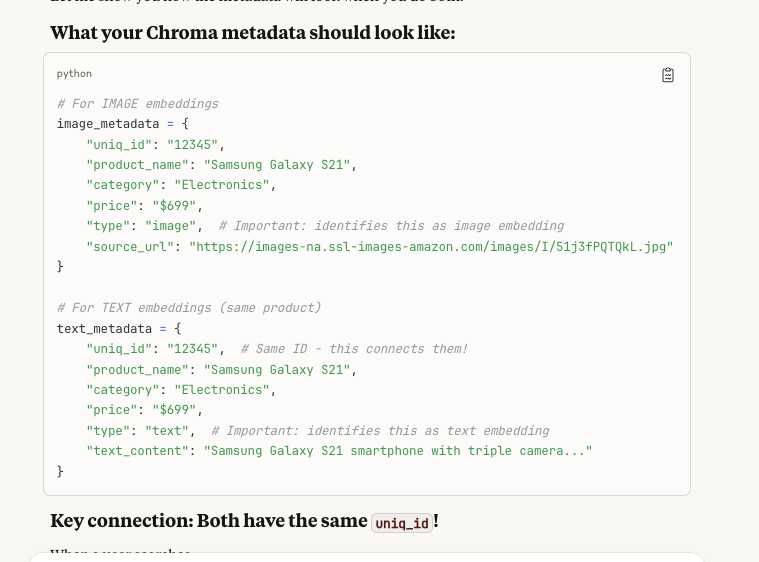

# OLD CODE

In [29]:
# HEAVIER METADATA
# def get_image_embedding_from_url(url_string, product_row):
#     """Download image from URL and get CLIP embedding + metadata - no saving on local"""
#     try:
#         uniq_id = product_row['Uniq Id']

#         # split by | and get all urls
#         urls = url_string.split('|')

#         # find first URL that is not a transparent pixel
#         for url in urls:
#             url = url.strip()
#             if 'transparent-pixel.jpg' not in url:
#                 print(f"Trying: {url}")

#                 # download to memory (not disk)
#                 response = requests.get(url)
#                 if response.status_code == 200:
#                     # get image
#                     image = Image.open(BytesIO(response.content))

#                     # get CLIP embedding
#                     embedding = get_image_embedding(image) # This just returns a numpy array - no metadata! I NEED TO ADD METADATA

#                     # Create Metadata

#                     # # very heavy metadata option
#                     # metadata = {
#                     #     "uniq_id": str(uniq_id),
#                     #     "product_name": product_row['Product Name'],
#                     #     "category": product_row['Category'],
#                     #     "price": str(product_row['Selling Price']),
#                     #     "type": "image", # Important: identifies this as image embedding. It is "text" for text
#                     #     "source_url": url
#                     # }

#                     print(f"Got embedding for {uniq_id}")
#                     return embedding, metadata

#     except Exception as e:
#         print(f"ERROR: {e}")
#         return None, None